In [ ]:
import polars as pl

inter = pl.read_parquet('/home/zhouzetong/yambda/flat/5b/listens.parquet')

In [3]:
import random

random.seed(42)
# inter = inter.filter(pl.col('item_id').is_in(set(embed['item_id'].to_list())))
# sampled_uid = random.sample(list(range(1,1_000_000)), 1_000)
# inter_sampled = inter.filter(pl.col('uid').is_in(sampled_uid))
inter_sampled = inter.filter(pl.col('timestamp') < 12_000_000)
# sampled_uid = random.sample(list(inter_sampled), 1_000)
# inter_sampled = inter.filter(pl.col('uid').is_in(sampled_uid))

In [4]:
import polars as pl

def filter_k_core(df, user_col="user_id", item_col="item_id", min_count=5):
    """
    对 DataFrame 进行 k-core 过滤（迭代直到收敛）
    输出每轮的统计信息
    """
    print(f"Starting {min_count}-core filtering...")
    print(f"Initial shape: {df.shape}")
    print(f"Unique users: {df[user_col].n_unique()}")
    print(f"Unique items: {df[item_col].n_unique()}")

    iter_count = 0
    while True:
        iter_count += 1
        print(f"\n--- Iteration {iter_count} ---")

        # 当前统计
        n_users = df[user_col].n_unique()
        n_items = df[item_col].n_unique()
        n_interactions = len(df)

        print(f"Users: {n_users}, Items: {n_items}, Interactions: {n_interactions}")

        # 统计每个 user 和 item 的出现频次
        user_counts = df.group_by(user_col).agg(pl.len().alias("user_freq"))
        item_counts = df.group_by(item_col).agg(pl.len().alias("item_freq"))

        # 筛选满足 min_count 的 user_id 和 item_id
        valid_users = user_counts.filter(pl.col("user_freq") >= min_count)
        valid_items = item_counts.filter(pl.col("item_freq") >= min_count)

        # 提取 ID 列用于 join
        valid_user_ids = valid_users.select(user_col)
        valid_item_ids = valid_items.select(item_col)

        # 内连接过滤
        df_filtered = (df
                       .join(valid_user_ids, on=user_col, how="inner")
                       .join(valid_item_ids, on=item_col, how="inner")
                      )

        # 新的统计
        n_users_new = df_filtered[user_col].n_unique()
        n_items_new = df_filtered[item_col].n_unique()
        n_interactions_new = len(df_filtered)

        print(f"After filtering: Users={n_users_new}, Items={n_items_new}, Interactions={n_interactions_new}")

        # 检查是否收敛（数量不再变化）
        if (n_users_new == n_users and n_items_new == n_items):
            print(f"\n✅ Converged! {min_count}-core filtering complete.")
            break

        df = df_filtered  # 更新用于下一轮

    return df_filtered


# 示例使用
if __name__ == "__main__":
    # 模拟数据
    # df = inter.filter(pl.col("click") == 1)
    df = inter_sampled.filter(pl.col("played_ratio_pct") >= 50)
    print(f"Number of interactions after filtering clicks: {len(df)}")
    df_5core = filter_k_core(df, user_col="uid", item_col="item_id", min_count=10)
    
    print("\nFinal DataFrame:")
    print(df_5core)

Number of interactions after filtering clicks: 1101084583
Starting 10-core filtering...
Initial shape: (1101084583, 6)
Unique users: 675400
Unique items: 3159820

--- Iteration 1 ---
Users: 675400, Items: 3159820, Interactions: 1101084583
After filtering: Users=642612, Items=1013714, Interactions=1095505531

--- Iteration 2 ---
Users: 642612, Items: 1013714, Interactions: 1095505531
After filtering: Users=642097, Items=1013566, Interactions=1095500751

--- Iteration 3 ---
Users: 642097, Items: 1013566, Interactions: 1095500751
After filtering: Users=642095, Items=1013497, Interactions=1095500123

--- Iteration 4 ---
Users: 642095, Items: 1013497, Interactions: 1095500123
After filtering: Users=642094, Items=1013495, Interactions=1095500098

--- Iteration 5 ---
Users: 642094, Items: 1013495, Interactions: 1095500098
After filtering: Users=642094, Items=1013493, Interactions=1095500080

--- Iteration 6 ---
Users: 642094, Items: 1013493, Interactions: 1095500080
After filtering: Users=642

In [5]:
def sparsity(df, user_col="uid", item_col="item_id"):
    return len(df) / (df[user_col].n_unique() * df[item_col].n_unique())
sparsity(df_5core)

0.0016834221936229525

In [6]:
# df_5core = df_5core.rename({"uid": "user_id:token", "item_id": "item_id:token", "timestamp": "timestamp:float"}).drop(["is_organic", "played_ratio_pct", "track_length_seconds"])
df_5core.write_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/inter.parquet')

In [7]:
item_ids = set(df_5core['item_id'].to_list())
embed = embed.filter(pl.col('item_id').is_in(item_ids))
embed.write_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/embedding.parquet')

In [12]:
album = pl.read_parquet('/home/zhouzetong/yambda/album_item_mapping.parquet')
artist = pl.read_parquet('/home/zhouzetong/yambda/artist_item_mapping.parquet')

In [13]:
item_ids = df_5core['item_id:token'].unique().to_list()

In [14]:
album_remain = album.filter(pl.col('item_id').is_in(item_ids))
artist_remain = artist.filter(pl.col('item_id').is_in(item_ids))
item_features = pl.concat([album_remain, artist_remain], how='align')

In [15]:
item_features = item_features.rename({"item_id": "item_id:token", "album_id": "album_id:token", "artist_id": "artist_id:token"})
item_features.write_csv('/home/zhouzetong/RecBole/dataset/yambda-620k/yambda-620k.item', separator='\t')

In [8]:
import polars as pl

embeddings = pl.read_parquet('/home/zhouzetong/yambda/embeddings.parquet')

In [2]:
import numpy as np
np_embed = np.array(embeddings['embed'].to_list())

In [25]:
import numpy as np

a = np.arange(1000, dtype=np.float32).reshape(100, 10)
a.fill(-1)

In [4]:
import polars as pl

embed_codes = pl.read_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/embedding_codes.parquet')

In [11]:
# Add a row index for stable ordering
df_with_index = embed_codes.with_row_index()

# Process the DataFrame using older-compatible syntax
result_df = df_with_index.with_columns(
    pl.when(pl.len().over("codes") > 1)
    .then(
        pl.col("codes").list.concat(
            # This line is changed to work with older Polars versions
            pl.col("index").rank(method="ordinal").over("codes").cast(pl.Int64)
        )
    )
    .otherwise(pl.col("codes"))
    .alias("codes")
).drop("index")

print(result_df)
result_df.write_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/embedding_codes_.parquet')

shape: (1_013_493, 5)
┌─────────┬────────────────────────┬────────────────────────┬───────────────────┬──────────────────┐
│ item_id ┆ embed                  ┆ normalized_embed       ┆ codes             ┆ codes_str        │
│ ---     ┆ ---                    ┆ ---                    ┆ ---               ┆ ---              │
│ u32     ┆ list[f64]              ┆ list[f64]              ┆ list[i64]         ┆ str              │
╞═════════╪════════════════════════╪════════════════════════╪═══════════════════╪══════════════════╡
│ 5       ┆ [0.832846, 0.116125, … ┆ [0.03149, 0.004391, …  ┆ [451, 192, … 1]   ┆ shape: (4,)      │
│         ┆ -1.4857…               ┆ -0.05617…              ┆                   ┆ Series: '' [i64] │
│         ┆                        ┆                        ┆                   ┆ […               │
│ 7       ┆ [-2.565061, 1.288959,  ┆ [-0.103322, 0.05192, … ┆ [175, 46, … 436]  ┆ shape: (4,)      │
│         ┆ … 1.3158…              ┆ 0.05300…               ┆        

In [1]:
import polars as pl

embed_codes = pl.read_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/embedding_codes_no_duplicates.parquet')

In [2]:
embed_codes = embed_codes.with_columns(
    pl.col("codes").map_elements(lambda x: str(x), return_dtype=str).alias("codes_str")
)

# 统计每个 codes_str 的出现次数
dup_groups = embed_codes.group_by("codes_str").agg(pl.count().alias("cnt")).filter(pl.col("cnt") > 1)

# 假设 embed_codes 有 'item_id' 或其它主键
dups = embed_codes.filter(pl.col("codes_str").is_duplicated())

# 按 codes_str 分组，收集所有重复行的索引或主键
grouped = dups.group_by("codes_str").agg([
    pl.col("item_id").alias("item_ids"),  # 如果有 item_id 字段
    pl.count().alias("dup_count")
])

print(grouped)

/tmp/ipykernel_783721/3371024451.py:2: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("codes").map_elements(lambda x: ...)
with this one instead:
  + pl.col("codes").cast(pl.String)

  pl.col("codes").map_elements(lambda x: str(x), return_dtype=str).alias("codes_str")
/tmp/ipykernel_783721/3371024451.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  dup_groups = embed_codes.group_by("codes_str").agg(pl.count().alias("cnt")).filter(pl.col("cnt") > 1)


shape: (0, 3)
┌───────────┬───────────┬───────────┐
│ codes_str ┆ item_ids  ┆ dup_count │
│ ---       ┆ ---       ┆ ---       │
│ str       ┆ list[u32] ┆ u32       │
╞═══════════╪═══════════╪═══════════╡
└───────────┴───────────┴───────────┘


/tmp/ipykernel_783721/3371024451.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("dup_count")


In [2]:
%env HTTPS_PROXY=http://127.0.0.1:7456
%env HTTP_PROXY=http://127.0.0.1:7456

env: HTTPS_PROXY=http://127.0.0.1:7456
env: HTTP_PROXY=http://127.0.0.1:7456


In [ ]:
import torch
from transformers import Qwen2ForCausalLM, AutoTokenizer, Qwen2Config

In [ ]:

config = Qwen2Config.from_pretrained("Qwen/Qwen2-1.5B", torch_dtype="bfloat16")
model = Qwen2ForCausalLM(config)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-1.5B")

In [7]:
tokenizer = AutoTokenizer.from_pretrained("model/qwen2-1.5b")

In [19]:
model.resize_token_embeddings(tokenizer.vocab_size+len(tokenizer.all_special_tokens), mean_resizing=False)
model.vocab_size = tokenizer.vocab_size + len(tokenizer.all_special_tokens)
model.config.bos_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id

In [36]:
text = "<|a_2|> <|a_1|> <|eos|>"
ids = tokenizer.encode(text)
ids

[1, 0, 2561]

In [8]:
tokenizer.apply_chat_template(
    [{
        "role": "user",
        "content": "Hello, how can I help you today?"
    }],
    tokenize=False
)

'Hello, how can I help you today?'

In [37]:
tokenizer.decode(ids)

'<|a_2|><|a_1|><|eos|>'

In [ ]:
model.save_pretrained('qwen2-1.5b')

('qwen2-1.5b/tokenizer_config.json',
 'qwen2-1.5b/special_tokens_map.json',
 'qwen2-1.5b/chat_template.jinja',
 'qwen2-1.5b/vocab.json',
 'qwen2-1.5b/merges.txt',
 'qwen2-1.5b/added_tokens.json',
 'qwen2-1.5b/tokenizer.json')

In [3]:
tokenizer.save_pretrained('qwen2-1.5b')

('qwen2-1.5b/tokenizer_config.json',
 'qwen2-1.5b/special_tokens_map.json',
 'qwen2-1.5b/chat_template.jinja',
 'qwen2-1.5b/vocab.json',
 'qwen2-1.5b/merges.txt',
 'qwen2-1.5b/added_tokens.json',
 'qwen2-1.5b/tokenizer.json')

In [31]:
import json

with open('model/111/tokenizer.json', 'r') as f:
    tokenizer_json = json.load(f)

In [33]:
special_tokens = ["<|a_{}|>", "<|b_{}|>", "<|c_{}|>", "<|d_{}|>", "<|e_{}|>"]
special_chars = [st.format(i) for st in special_tokens for i in range(1, 513)]

In [34]:
tokenizer.add_special_tokens({"additional_special_tokens": special_chars})

2560

In [1]:
import polars as pl

inter = pl.read_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/inter.parquet')

In [3]:
# 按用户分组，收集每个用户的物品交互序列
user_sequences = inter.group_by("uid").agg([
    pl.col("item_id"),
    pl.col("timestamp")
])

In [5]:
user_sequences = user_sequences.sort("uid")

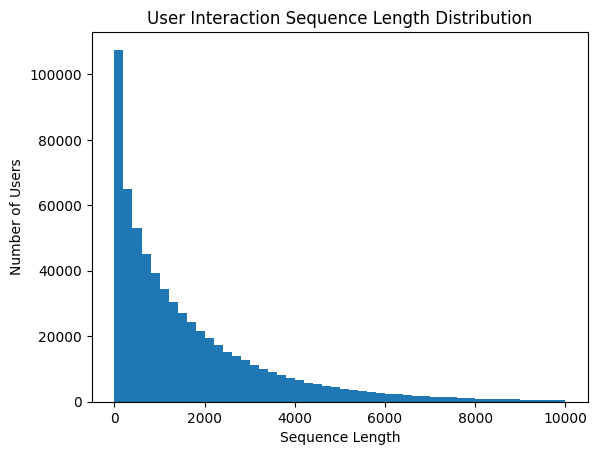

In [9]:
import matplotlib.pyplot as plt

plt.hist(lens, bins=50, range=(0, 10000))
plt.xlabel("Sequence Length")
plt.ylabel("Number of Users")
plt.title("User Interaction Sequence Length Distribution")
plt.show()

In [ ]:
from transformers import Blip2Config

In [7]:
user_sequences.write_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/seq.parquet')

In [5]:
import pyarrow as pa

with open('/home/zhouzetong/LLaMA-Factory/saves/dataset/yambda-620k/train/data-00000-of-00036.arrow', 'rb') as f:
    reader = pa.ipc.open_stream(f)
    table = reader.read_all()

df = table.to_pandas()

In [6]:
df.iloc[0]

input_ids         [2560, 2560, 2560, 2560, 2560, 2560, 2560, 256...
attention_mask    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
labels            [-100, 2560, 2560, 2560, 2560, 2560, 2560, 256...
images                                                         None
videos                                                         None
audios                                                         None
Name: 0, dtype: object

In [1]:
import polars as pl

data = pl.read_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/inter.parquet')

In [4]:
data = data.to_pandas()

In [2]:
data = data.rename({'uid':'user_id:token', 'item_id':'item_id:token', 'timestamp': 'timestamp:float'})\
    .drop(['is_organic', 'played_ratio_pct', 'track_length_seconds'])

In [3]:
data.write_csv('/home/zhouzetong/RecBole/dataset/yambda-620k/yambda-620k.inter', separator='\t')

In [1]:
import polars as pl

data = pl.read_csv('/home/zhouzetong/RecBole/dataset/yambda-620k/yambda-620k.inter', separator='\t')

In [7]:
import polars as pl

data = pl.read_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/val_sft.parquet')
data[0]

instruction,input,output
str,str,str
"""<|a_209|><|b_378|><|c_188|><|d…","""""","""<|a_429|><|b_230|><|c_507|><|d…"


In [8]:
data.row(0,named=True)

{'instruction': '<|a_209|><|b_378|><|c_188|><|d_38|><|sep|><|a_350|><|b_213|><|c_371|><|d_465|><|sep|><|a_209|><|b_496|><|c_371|><|d_6|><|sep|><|a_124|><|b_392|><|c_397|><|d_378|><|e_2|><|sep|><|a_471|><|b_384|><|c_119|><|d_392|><|sep|><|a_27|><|b_34|><|c_454|><|d_353|><|e_1|><|sep|><|a_418|><|b_103|><|c_266|><|d_97|><|sep|><|a_493|><|b_410|><|c_282|><|d_462|><|e_3|><|sep|><|a_54|><|b_429|><|c_35|><|d_18|><|sep|><|a_354|><|b_241|><|c_376|><|d_302|><|sep|><|a_368|><|b_398|><|c_29|><|d_434|><|sep|><|a_511|><|b_279|><|c_354|><|d_222|><|sep|><|a_300|><|b_279|><|c_354|><|d_347|><|sep|><|a_183|><|b_222|><|c_502|><|d_350|><|sep|><|a_88|><|b_211|><|c_376|><|d_405|><|sep|><|a_368|><|b_350|><|c_354|><|d_306|><|sep|><|a_222|><|b_284|><|c_354|><|d_95|><|sep|><|a_245|><|b_188|><|c_142|><|d_450|><|sep|><|a_187|><|b_476|><|c_206|><|d_107|><|sep|><|a_88|><|b_18|><|c_454|><|d_380|><|sep|><|a_422|><|b_297|><|c_175|><|d_132|><|sep|><|a_37|><|b_231|><|c_160|><|d_354|><|sep|><|a_187|><|b_392|><|c_261|><|d_

In [1]:
import torch
from transformers import Qwen2ForCausalLM, AutoTokenizer, Qwen2Config

device = torch.device('cuda:6')
path = "/home/zhouzetong/LLaMA-Factory/saves/qwen2/full/yambda"
model = Qwen2ForCausalLM.from_pretrained(
    path,
    torch_dtype=torch.bfloat16
).to(device)
tokenizer = AutoTokenizer.from_pretrained(path)

In [2]:
import polars as pl

val = pl.read_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/val_sft.parquet')

In [3]:
text = val.row(0, named=True)['instruction']
inputs = tokenizer(
    [text, val.row(1, named=True)['instruction']],
    return_tensors='pt',
)
inputs

{'input_ids': tensor([[ 208,  889, 1211,  ..., 1353, 1751, 2560],
        [  29,  529, 1336,  ..., 1213, 1970, 2560]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [4]:
from transformers import StoppingCriteria

class StopOnTokenCriteria(StoppingCriteria):
    def __init__(self, stop_token_id: int):
        self.stop_token_id = stop_token_id

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        # 检查最新生成的 token 是否是我们的停止 token
        # input_ids[:, -1] 获取了批处理中每个序列的最后一个 token
        if input_ids[0, -1] == self.stop_token_id:
            return True # 如果是，则返回 True，表示停止生成
        return False # 否则返回 False，继续生成

output = model.generate(
    inputs["input_ids"].to(device),
    attention_mask=inputs["attention_mask"].to(device),
    max_new_tokens=10,
    eos_token_id=2560,
    pad_token_id=2562,
    num_beams=5,
    num_return_sequences=5,
    output_scores=True,
    return_dict_in_generate=True
)

In [5]:
output['sequences'][:,len(inputs["input_ids"][0]):]

tensor([[ 208,  724, 1284, 1695, 2560, 2562],
        [ 208,  808, 1401, 1611, 2560, 2562],
        [ 265,  604, 1260, 1895, 2050, 2560],
        [  26,  545, 1477, 1888, 2048, 2560],
        [  26,  545, 1477, 1888, 2049, 2560],
        [  53,  590, 1312, 1617, 2049, 2560],
        [ 103,  953, 1289, 1615, 2048, 2560],
        [ 181,  950, 1051, 1844, 2560, 2562],
        [ 181,  953, 1331, 1771, 2560, 2562],
        [ 103,  953, 1184, 1923, 2560, 2562]], device='cuda:6')

In [ ]:
tokenizer.batch_decode(output)

tensor([-0.6337, -0.6863, -0.7142, -0.7220, -0.7489, -0.7906, -0.8189, -0.8372,
        -0.8865, -0.8939, -0.9095, -0.9522, -0.9534, -0.9538, -0.9678, -0.9723,
        -0.9759, -0.9938, -1.0129, -1.0182], device='cuda:7')

In [6]:
import torch
torch.set_printoptions(profile="full")

In [ ]:
output[:,len(inputs["input_ids"][0]):]

In [10]:
tokenizer(val.row(0, named=True)['output'])

{'input_ids': [428, 741, 1530, 1793, 2560], 'attention_mask': [1, 1, 1, 1, 1]}

In [1]:
import polars as pl
from typing import List
embed_codes = pl.read_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/embedding_codes_no_duplicates.parquet')

def codes_to_string(codes: List[int]) -> str:
    """将codes转换为字符串，使用更高效的方法"""
    return ''.join(f"<|{chr(97+i)}_{code}|>" for i, code in enumerate(codes))

embed_codes = embed_codes.with_columns(
    pl.col('codes').map_elements(codes_to_string, return_dtype=pl.Utf8).alias('code_str')
)

# item2codes = [{'item_id': item_id, 'code_str': code_str} for item_id, code_str in zip(embed_codes['item_id'].to_list(), embed_codes['code_str'].to_list())]

In [2]:
item2codes = dict(zip(embed_codes['item_id'].to_list(), embed_codes['code_str'].to_list()))

In [24]:
seq2 = pl.read_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/seq.parquet')

In [32]:
seq2.with_row_index().filter(pl.col('uid') == 3)

index,uid,item_sequence,seq_length
u32,u32,list[u32],u32
7904,3,"[6861837, 8039663, … 616275]",5446


In [3]:
seq = pl.read_parquet('/home/zhouzetong/yambda/benchmarks/data/sequential/5b/listens.parquet')

In [42]:
train = pl.read_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/train_sft.parquet')

In [4]:
val = pl.read_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/val_sft.parquet')
test = pl.read_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/test_sft.parquet')

In [45]:
train.row(7904)

('<|a_497|><|b_136|><|c_388|><|d_188|><|sep|>',
 '',
 '<|a_30|><|b_212|><|c_439|><|d_343|><|sep|><|a_238|><|b_30|><|c_502|><|d_313|><|sep|><|a_175|><|b_442|><|c_27|><|d_103|><|sep|><|a_175|><|b_356|><|c_295|><|d_292|><|sep|><|a_65|><|b_353|><|c_443|><|d_147|><|sep|><|a_30|><|b_179|><|c_193|><|d_314|><|sep|><|a_65|><|b_187|><|c_503|><|d_31|><|sep|><|a_355|><|b_77|><|c_413|><|d_79|><|sep|><|a_187|><|b_34|><|c_18|><|d_294|><|sep|><|a_104|><|b_232|><|c_266|><|d_380|><|sep|><|a_30|><|b_310|><|c_35|><|d_18|><|sep|><|a_187|><|b_497|><|c_280|><|d_511|><|sep|><|a_212|><|b_439|><|c_115|><|d_388|><|sep|><|a_175|><|b_313|><|c_60|><|d_12|><|e_1|><|sep|><|a_266|><|b_439|><|c_497|><|d_388|><|e_2|><|sep|><|a_179|><|b_416|><|c_497|><|d_65|><|sep|><|a_459|><|b_103|><|c_360|><|d_427|><|e_2|><|sep|><|a_30|><|b_212|><|c_35|><|d_498|><|sep|><|a_497|><|b_231|><|c_206|><|d_107|><|sep|><|a_280|><|b_212|><|c_212|><|d_311|><|sep|><|a_30|><|b_483|><|c_187|><|d_145|><|sep|><|a_175|><|b_429|><|c_30|><|d_388|><|sep|

In [36]:
val.row(7904)

('<|a_209|><|b_171|><|c_241|><|d_41|><|sep|><|a_350|><|b_261|><|c_190|><|d_259|><|sep|><|a_368|><|b_421|><|c_434|><|d_166|><|sep|><|a_139|><|b_265|><|c_142|><|d_279|><|sep|><|a_99|><|b_104|><|c_368|><|d_261|><|sep|><|a_261|><|b_413|><|c_306|><|d_213|><|sep|><|a_306|><|b_378|><|c_29|><|d_306|><|sep|><|a_306|><|b_378|><|c_29|><|d_306|><|sep|><|a_378|><|b_86|><|c_10|><|d_436|><|sep|><|a_99|><|b_104|><|c_183|><|d_368|><|sep|><|a_261|><|b_366|><|c_368|><|d_230|><|sep|><|a_368|><|b_279|><|c_496|><|d_466|><|sep|><|a_342|><|b_378|><|c_450|><|d_66|><|sep|><|a_436|><|b_346|><|c_436|><|d_95|><|sep|><|a_272|><|b_442|><|c_335|><|d_160|><|sep|><|a_444|><|b_241|><|c_14|><|d_21|><|sep|><|a_378|><|b_354|><|c_128|><|d_16|><|sep|><|a_67|><|b_450|><|c_287|><|d_335|><|sep|><|a_279|><|b_230|><|c_122|><|d_202|><|sep|><|a_342|><|b_181|><|c_342|><|d_342|><|sep|><|a_328|><|b_328|><|c_124|><|d_303|><|sep|><|a_290|><|b_142|><|c_142|><|d_36|><|e_1|><|sep|><|a_290|><|b_328|><|c_142|><|d_130|><|e_1|><|sep|><|a_182|>

In [41]:
item2codes[seq.row(0)[2][-3]]

'<|a_335|><|b_439|><|c_289|><|d_272|>'

In [6]:
pl.DataFrame(item2codes).write_parquet('/home/zhouzetong/Rec-RL/data/yambda-620k/item2codes.parquet')

In [9]:
itemcodes = pl.DataFrame(item2codes)

In [31]:
codes = itemcodes['code_str'].to_list()

In [ ]:
from tqdm import tqdm
bar = tqdm(itemcodes.iter_rows(named=True), total=len(itemcodes))
codes = [tokenizer(inputs['code_str'])['input_ids'] for inputs in bar]

In [29]:
codes[1]

[174, 557, 1127, 1971]

In [26]:
tokenizer(a[0]['code_str'])

{'input_ids': [450, 703, 1224, 1892, 2048], 'attention_mask': [1, 1, 1, 1, 1]}

In [1]:
import numpy as np

codes = np.load('/home/zhouzetong/Rec-RL/data/Instruments/codes.npy') + 1

In [28]:
import polars as pl

codes = pl.DataFrame({'codes': [list(c) for c in codes]})

TypeError: not yet implemented: Nested object types

Hint: Try setting `strict=False` to allow passing data with mixed types.

In [3]:
codes

codes
list[i32]
"[97, 72, 129]"
"[8, 249, 97]"
"[8, 44, 94]"
"[169, 149, 228]"
"[183, 129, 138]"
…
"[2, 99, 87]"
"[158, 61, 40]"
"[189, 242, 22]"


In [4]:
codes_str = codes.with_columns(
    pl.col("codes").map_elements(lambda x: ','.join(map(str, x)), return_dtype=pl.Utf8).alias("codes_str")
)

# 按 codes_str 分组计算重复数量
result = (codes_str
          .group_by("codes_str")
          .count()
          .sort("count", descending=True)
         )

print(result)

shape: (9_053, 2)
┌─────────────┬───────┐
│ codes_str   ┆ count │
│ ---         ┆ ---   │
│ str         ┆ u32   │
╞═════════════╪═══════╡
│ 137,194,174 ┆ 16    │
│ 178,124,226 ┆ 15    │
│ 137,102,102 ┆ 12    │
│ 137,102,226 ┆ 10    │
│ 125,124,226 ┆ 9     │
│ …           ┆ …     │
│ 217,41,69   ┆ 1     │
│ 145,55,22   ┆ 1     │
│ 203,57,201  ┆ 1     │
│ 198,218,50  ┆ 1     │
│ 51,55,107   ┆ 1     │
└─────────────┴───────┘


/tmp/ipykernel_4061980/508520434.py:8: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


In [5]:
def deal_with_dedupilcate(df):
    df_with_index = df.with_row_index()

    # Process the DataFrame using older-compatible syntax
    result_df = df_with_index.with_columns(
        pl.when(pl.len().over("codes") > 1)
        .then(
            pl.col("codes").list.concat(
                # This line is changed to work with older Polars versions
                pl.col("index").rank(method="ordinal").over("codes").cast(pl.Int64)
            )
        )
        .otherwise(pl.col("codes"))
        .alias("codes")
    ).drop("index")

    return result_df

result = deal_with_dedupilcate(codes)
result

codes
list[i64]
"[97, 72, 129]"
"[8, 249, 97]"
"[8, 44, 94]"
"[169, 149, 228]"
"[183, 129, 138]"
…
"[2, 99, 87]"
"[158, 61, 40]"
"[189, 242, 22]"


In [6]:
from collections import defaultdict
import random

codes_json = {}
codes_map = defaultdict(list)
codes_set = set()

for id, row in enumerate(result.iter_rows(named=True)):
    codes_ = []
    for i, code in enumerate(row['codes']):
        codes_.append((f'<|{chr(97+i)}_{code}|>'))
    # if str(codes_) not in codes_set:
    #     codes_set.add(str(codes_))
    # else:
    #     s_code = random.randint(1,256)
    #     while s_code in codes_map[str(codes_)]:
    #         s_code = random.randint(1,256)
    #     codes_map[str(codes_)].append(s_code)
    #     codes_.append((f'<|e_{s_code}|>'))
    codes_json[str(id)] = codes_

In [8]:
import json

with open('/home/zhouzetong/Rec-RL/data/Instruments/Instruments.index.json', 'w') as f:
    json.dump(codes_json, f, indent=2)

In [3]:
import polars as pl
train = pl.read_parquet('/home/zhouzetong/Rec-RL/ckpt/Instruments/train_data.parquet')

In [4]:
train_json = train.to_dicts()

In [6]:
import json
with open('/home/zhouzetong/Rec-RL/LLaMA-Factory/data/Instruments.json', 'w') as f:
    json.dump(train_json, f, indent=2)

In [1]:
def read_index(file):
    unit2index = {}
    with open(file, 'r') as fp:
        lines = fp.readlines()
        for line in lines:
            unit, index = line.strip().split('\t')
            unit2index[unit] = str(index)
    return unit2index

item2id_old = read_index('/home/zhouzetong/Rec-RL/data/Sports/Sports.item2id')
item2id_new = read_index('/home/zhouzetong/Rec-RL/data/Sports1/Sports1.item2id')

In [3]:
revers_old_map = {v: k for k, v in item2id_old.items()}

In [5]:
import json
def load_json(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return data

index = load_json('/home/zhouzetong/Rec-RL/data/Sports/Sports.index.json')

index_new = {}

for old_id, value in index.items():
    item = revers_old_map[old_id]
    id_new = item2id_new[item]
    index_new[id_new] = value

In [10]:
d=index_new

In [11]:
sorted_dict = {k: d[k] for k in sorted(d)}

In [12]:
with open('/home/zhouzetong/Rec-RL/data/Sports1/Sports.index.json', 'w') as f:
    json.dump(sorted_dict, f, indent=2)

In [21]:
import json

with open('/home/zhouzetong/Rec-RL/data/Amazon/Sports.user.json', 'r') as f:
    s1 = json.load(f)

avg_len = 0
for k,v in s1['user_explicit_preference'].items():
    avg_len += sum([len(s.split()) for s in v])
avg_len / len(s1['user_explicit_preference'])

268.37212764762063

In [23]:
avg_len

9553511

In [24]:
len(s1['user_explicit_preference'])

35598

In [20]:
import json

with open('/home/zhouzetong/Rec-RL/data/Sports/user_preference.jsonl', 'r') as f:
    s2 = [json.loads(line) for line in f]
avg_len2 = 0
for item in s2:
    v = item['user_preference']
    avg_len2 += sum([len(s.split()) for s in v])
avg_len2 / len(s2)

126.32244318181819

In [22]:
len(s2)

704

In [25]:
with open('/home/hongminjie/work/LC-Rec-A800/LC-Rec/data/Sports/Raw_Data/Sports.user2id', 'r') as f:
    s3 = f.readlines()

In [26]:
len(s3)

35598

In [4]:
! pwd

/home/zhouzetong


In [1]:
import sys
sys.path.append('/home/zhouzetong/Rec-RL')
from data_process.utils import item_feature_prompt
print(item_feature_prompt)

Based on the following information for an item named "{item_title}", including its original description and a collection of user reviews, please generate a comprehensive and objective summary of the item's key features and characteristics. The summary should be neutral and focus solely on the intrinsic properties of the item, avoiding any user-specific opinions, preferences, or sentiments expressed in the reviews. And the summary should be a concise paragraph, focusing on key features.
Here is the item description: {item_description} And the user reviews:
{user_reviews}
Please provide the item's features in the following format:
The item's features: [item features]


In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("/home/zhouzetong/Rec-RL/model/qwen3-4b-instruct")

In [19]:
tokenizer("\n")

{'input_ids': [198], 'attention_mask': [1]}

In [14]:
import pyarrow.ipc as ipc

with open('/home/zhouzetong/Rec-RL/LLaMA-Factory/saves/instruments/train/data-00000-of-00004.arrow', 'rb') as f:
    reader = ipc.RecordBatchStreamReader(f)
    table = reader.read_all()

df = table.to_pandas()
print(df)

                                                input_ids  \
0       [151644, 872, 198, 8420, 525, 279, 1196, 594, ...   
1       [151644, 872, 198, 16429, 279, 1196, 594, 1365...   
2       [151644, 872, 198, 40, 1477, 279, 1196, 594, 1...   
3       [151644, 872, 198, 785, 1196, 702, 16282, 291,...   
4       [151644, 872, 198, 8420, 525, 279, 1196, 594, ...   
...                                                   ...   
311129  [151644, 872, 198, 11598, 6334, 279, 4565, 552...   
311130  [151644, 872, 198, 11598, 6334, 279, 4565, 552...   
311131  [151644, 872, 198, 2121, 264, 27682, 1849, 11,...   
311132  [151644, 872, 198, 2121, 264, 27682, 1849, 11,...   
311133  [151644, 872, 198, 32, 1196, 702, 4091, 1493, ...   

                                           attention_mask  \
0       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3       [1, 1, 1, 1, 1,

In [9]:
import json

with open('/home/zhouzetong/Rec-RL/LLaMA-Factory/data/Instruments.json', 'r') as f:
    instruments = json.load(f)
    
instruments[0]

{'conversations': [{'from': 'human',
   'value': "Here are the user's historical interactions: <|a_214|><|b_24|><|c_97|>, try to recommend another item to the user. Note that the historical interactions are arranged in chronological order."},
  {'from': 'gpt', 'value': '<|a_202|><|b_26|><|c_168|>'}]}

In [18]:
df.loc[0, 'input_ids']

array([151644,    872,    198,   8420,    525,    279,   1196,    594,
        13656,  21880,     25,    220, 151882, 151948, 152277,     11,
         1430,    311,   6934,   2441,   1509,    311,    279,   1196,
           13,   7036,    429,    279,  13656,  21880,    525,  27802,
          304,  86534,   1973,     13, 151645,    198, 151644,  77091,
          198, 151870, 151950, 152348, 151645,    198], dtype=int32)

In [27]:
tokenizer.decode(df.loc[10, 'input_ids'])

"<|im_start|>user\nUsing the user's historical interactions as input data, suggest the next item that the user is highly likely to enjoy. The historical interactions are provided as follows: <|a_205|><|b_172|><|c_207|>, <|a_42|><|b_100|><|c_234|>, <|a_49|><|b_182|><|c_97|>.<|im_end|>\n<|im_start|>assistant\n<|a_76|><|b_76|><|c_179|><|d_2|><|im_end|>\n"

In [3]:
s = "<|a_3|><|b_4|>"
s.strip('<|>').split('|><|')

['a_3', 'b_4']

In [1]:
from verl.reward import compute_score

response = """
<think> 
Step 4: 
SONY MDR-EX15LP earphone is the best choice 
</think>
<answer><|a_1|><|b_1|><|c_3|></answer><|im_end|>

"""

compute_score('', response, '<|a_1|><|b_2|><|c_3|>', {'title': 'SONY earphone'})

{'format': 1.0, 'acc': 0.2, 'consistency': 0.5, 'score': 0.53}

In [20]:
response.replace("<|im_end|>", "")

'\n<think> \nStep 4: \nSONY MDR-EX15LP earphone is the best choice \n</think>\n<answer><|a_1|><|b_1|><|c_3|></answer>\n\n'

In [2]:
import json

with open('/home/zhouzetong/Rec-RL/responses/0/100.jsonl', 'r') as f:
    data = [json.loads(line) for line in f]


In [7]:
print(data[2000]['output'].replace("<|endoftext|>",""))

<think>
**Step 1: Analysis of Purchase History**  
The user’s purchase history shows two categories of musical instrument items:  
- **Recording Equipment:** A Zoom H1 Handy Portable Digital Recorder, designed for capturing professional audio.  
- **Guitar Accessories:** A set of traditional brass fingerpicks, indicating a dedicated recording setup for acoustic guitar.  

The purchase pattern reflects an interest in both *quality instruments/flutter accessories* (fingerpicks chosen for durability and performance) and *core recording gear* (recorder chosen for portability and high sound fidelity). This user values sound quality and reliability in their instruments and accessories, aligning with professional-level applications.  

---

**Step 2: Construction of User Persona**  
The user is an experienced musician with a focus on high-quality, durable gear, particularly in the acoustic guitar category. They have an interest in both performance and recording, showing a blend of live playin

In [5]:
data[0]

{'input': "<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

Step 140: {'recall@5': 0.05625, 'recall@10': 0.06294642857142857, 'ndcg@5': 0.05292215649648939, 'ndcg@10': 0.055078874516657335, 'precision@5': 0.04723214285714287, 'precision@10': 0.03879464285714287}
Step 300: {'recall@5': 0.06015625, 'recall@10': 0.06484375, 'ndcg@5': 0.057300370278116776, 'ndcg@10': 0.05886834905953846, 'precision@5': 0.051796874999999985, 'precision@10': 0.04234375000000001}

In [1]:
import json

with open('/home/zhouzetong/Rec-RL/LLaMA-Factory/data/Instruments_wo_feature.json', 'r') as f:
    data = json.load(f)

with open('/home/zhouzetong/Rec-RL/LLaMA-Factory/data/instruments-sft.json', 'r') as f:
    data2 = json.load(f)

In [2]:
import random
random.seed(42)

mix = random.sample(data, 30_000) + data2 * 3

In [3]:
with open('/home/zhouzetong/Rec-RL/LLaMA-Factory/data/instruments-sft3.json', 'w') as f:
    json.dump(mix, f, indent=2)

In [1]:
import json

with open('/home/zhouzetong/Rec-RL/data/Instruments/Instruments.index.json', 'r') as f:
    index = json.load(f)
    
index['0']

['<|a_94|>', '<|b_105|>', '<|c_115|>', '<|d_166|>']